In [1]:
# !pip install onnxruntime-gpu insightface

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]   
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1673 kB]
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:7 https://packages.cloud.google.com/apt google-fast-socket InRelease [1071 B]
Get:8 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [26.3 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1517 kB]
Get:11 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3232 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univ

In [1]:
import os
import json

from PIL import Image
from tqdm.notebook import tqdm
import gc
import numpy as np
import pandas as pd
import time
import copy
from collections import Counter
import ast
import random

# from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold

from timm.scheduler.scheduler import Scheduler
from timm.loss import LabelSmoothingCrossEntropy
import timm

from torchvision import transforms as T
import torchvision

import cv2
# import insightface
# from insightface.app import FaceAnalysis
# from insightface.data import get_image as ins_get_image
import matplotlib.pyplot as plt

2024-09-12 04:50:15.067987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 04:50:15.068117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 04:50:15.202373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Preparation for ABAW

In [2]:
def data_builder(label_path, train = True):
    # read annotations
    df = pd.read_csv(label_path, names = ['image', 'val', 'arousal', 'expr', 'au1', 'au2', 'au3', 'au4', 'au5', 'au6', 'au7', 'au8', 'au9', 'au10', 'au11', 'au12'] )
    # Remove the first row
    df = df.drop(index=0)

    # reset index
    df = df.reset_index(drop=True)

    df[['folder', 'image']] = df['image'].str.split('/', expand=True)

    grouped = df.groupby(['folder'], as_index= False).apply(lambda x: x.sort_values('image'))
    grouped['expr'] = grouped['expr'].astype(int)
    grouped = grouped.reset_index(drop=True)

    # generating data dictionary
    data_dict = {}
    emo = ['Neutral', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness','Surprise', 'Other']
    seq = 0
    current = -1
    for index, row in grouped.iterrows():
        if row['expr'] != current:
            current = row['expr']
            if train:
                seq += 1

        if row['expr'] == -1:
            continue

        if row['folder'] in data_dict:
            data_dict[row['folder']].append(
                (os.path.join(row['folder'], row['image']), row['expr'])
            )
        else:
            data_dict[row['folder']] = [(os.path.join(row['folder'], row['image']), row['expr']), ]
            
    return data_dict

def most_common_element(lst):
    if not lst:
        return None  # Return None if the list is empty
    counter = Counter(lst)
    most_common = counter.most_common(1)[0]  # Get the most common element
    return most_common[0]

def sequence_extractor(data_dict, data_path, min_stride = 5, sequence_length = 5, train = True):
    train_seqs = []
    train_labels = []
    for folder in data_dict.keys():
        s_len = len(data_dict[folder])
        max_start_index = s_len - (sequence_length - 1) * min_stride
        for i in range(0, max_start_index, sequence_length * min_stride):
            sublist = [os.path.join(data_path, data_dict[folder][i + j * min_stride][0]) for j in range(5)]
            train_seqs.append(sublist)
            t_lab = [data_dict[folder][i + j * min_stride][1] for j in range(5)]

            train_labels.append(most_common_element(t_lab))
    return train_seqs, train_labels


In [4]:
# len(data_dict['107']['Other0'])
val_seq = []
val_labels = []
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'


def most_common_element(lst):
    if not lst:
        return None  # Return None if the list is empty
    counter = Counter(lst)
    most_common = counter.most_common(1)[0]  # Get the most common element
    return most_common[0]

stride = 4
for key in data_dict.keys():
    for exp in data_dict[key].keys():
        n = len(data_dict[key][exp])
        # Calculate the maximum starting index that allows creating a sublist of length 5
        max_start_index = n - (5 - 1) * stride
        for i in range(0, max_start_index, 5 * stride):
            sublist = [os.path.join(data_path, data_dict[key][exp][i + j * stride][0]) for j in range(5)]
            val_seq.append(sublist)
            t_lab = [data_dict[key][exp][i + j * stride][1] for j in range(5)]
            
            val_labels.append(most_common_element(t_lab))


len(val_seq)
# data_dict['107']['Other0'][0]

NameError: name 'data_dict' is not defined

In [3]:
class ABAWFeatureDataset(Dataset):
    def __init__(self, features, labels, transform = None):
        self.features = features
        self.labels = labels
        self.length = len(labels)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        frames = [Image.open(i).convert('RGB') for i in self.features[idx]]
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        frames = torch.stack(frames)        # Stack frames to form a 4D tensor (T, C, H, W)
        frames = frames.permute(1, 0, 2, 3)  # Change order to (C, T, H, W)
        label = self.labels[idx]
        return frames, label

In [2]:
def get_analysis_train_dataloader(data_path, label_path, batch_size, num_epochs = 20, epochs = 0):

    dataset_train = RAFDBDataset(choose="train",
        data_path=data_path,
        label_path=label_path,
        app = None,
        transform = None,
        img_size = 224,
        num_epochs = num_epochs,
        epochs = epochs
                                 
    )

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        drop_last=True,
    )
    return data_loader_train, dataset_train.length, dataset_train


def get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = 20, epochs = 0):

    dataset_val = RAFDBDataset(choose="test",
        data_path=data_path,
        label_path=label_path,
        app = None,        
        transform = None,
        img_size = 224,
        num_epochs = num_epochs,
        epochs = epochs
    )

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )
    return data_loader_val, dataset_val.length, dataset_val

In [3]:
landmarks_cache = {}

# Open the file and read all lines first to calculate total length for progress bar
with open('/kaggle/input/raf-db-trial/keypoints.txt', 'r') as file:
    lines = file.readlines()

# Iterate over lines with progress bar
for line in tqdm(lines, desc="Processing landmarks", unit="lines"):
    # Split at the first occurrence of the colon
    file_name, coordinates = line.split(":", 1)

    # Remove whitespace around the file name
    file_name = file_name.strip()

    # Convert the string representation of the list of tuples to an actual list of tuples
    coordinates = ast.literal_eval(coordinates.strip())

    # Add to the dictionary
    landmarks_cache[file_name] = coordinates

Processing landmarks:   0%|          | 0/15308 [00:00<?, ?lines/s]

In [4]:
class RandomMasking:
    def __init__(self, mask_size=32, num_masks=5):
        """
        Initialize the masking transformation.
        mask_size: Size of the square mask (in pixels).
        num_masks: Number of random masks to apply.
        """
        self.mask_size = mask_size
        self.num_masks = num_masks

    def __call__(self, img):
        """
        Apply random masks to the image.
        img: Tensor image (C, H, W)
        """
        # Get image dimensions
        _, h, w = img.shape
        
        # Mask the image `num_masks` times
        for _ in range(self.num_masks):
            # Randomly choose top-left corner of the mask
            x = random.randint(0, w - self.mask_size)
            y = random.randint(0, h - self.mask_size)
            
            # Apply the mask (zero out the pixels in the selected region)
            img[:, y:y+self.mask_size, x:x+self.mask_size] = 0
        
        return img

In [9]:
class RAFDBDataset(Dataset):
    def __init__(self, choose, data_path, label_path, app, transform=None, img_size=224, num_epochs = 20, epochs = 0):
        self.image_paths = []
        self.labels = []
        self.data_path = data_path
        self.label_path = label_path
        self.app = app
        self.landmarks_cache = landmarks_cache  # Cache to store landmark coordinates
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epoch = num_epochs
        self.epochs = epochs

        if transform:
            self.transform = transform
        else:
            self.transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
            ])

        self.train = True if choose == "train" else False

        if choose == "train" or choose == "test":
            with open(self.label_path, "r") as f:
                data = f.readlines()

            for i in range(0, len(data)):
                line = data[i].strip('\n').split(" ")

                image_name = line[0]
                sample_temp = image_name.split("_")[0]

                if self.train and sample_temp == "train":
                    image_path = os.path.join(self.data_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(int(line[1]) - 1)

                elif not self.train and sample_temp == "test":
                    image_path = os.path.join(self.data_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(int(line[1]) - 1)
                    
        self.length = len(self.labels)
        self.labels = np.asarray(self.labels)

    def draw_squares_on_landmarks(self, img, landmarks, n):
        dimg = img.copy()
        if n == 0:
            return dimg
        half_n = n // 2
        for kp in landmarks:
            # Ensure coordinates are integers
            top_left = (int(kp[0] - half_n), int(kp[1] - half_n))
            bottom_right = (int(kp[0] + half_n), int(kp[1] + half_n))
            cv2.rectangle(dimg, top_left, bottom_right, (0, 0, 0), -1)  # -1 fills the rectangle
        return dimg

    def get_landmarks(self, img_path):
        if img_path not in self.landmarks_cache:
            return None
            img = cv2.imread(img_path)
            nimg = cv2.resize(img, (224,224))
            k = 100
            padded_image = cv2.copyMakeBorder(
                nimg,
                k,
                k,
                k,
                k,
                cv2.BORDER_CONSTANT,  # Border type
                value=[0, 0, 0]       # Padding color (black in this case)
            )
#             padded_image = padded_image.to(self.device)  # Ensure the image is on the right device
            out = self.app.get(padded_image)
            
            if len(out) == 0:  # Check if any faces were detected
                return None
            
            landmarks = out[0].landmark_2d_106.astype(np.int64)
            self.landmarks_cache[img_path] = landmarks
        return self.landmarks_cache[img_path]

    def augment(self, img_path):
        img = cv2.imread(img_path)
        nimg = cv2.resize(img, (224, 224))
        landmarks = self.get_landmarks(img_path.split('/')[-1])
#         print(landmarks)
        if landmarks is None:  # Skip if no faces are detected
            return nimg, nimg
        
        # Use landmarks to draw squares on the padded image
        aug = self.draw_squares_on_landmarks(nimg, landmarks, n=max(0, 5 - self.epochs))
#         plt.imshow(aug)
#         plt.axis('off')  # Optional: turn off axes
#         plt.show()
        return nimg, aug

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img1, img2 = self.augment(img_path)
        
        if self.transform:
            img1 = self.transform(Image.fromarray(img1))
            img2 = self.transform(Image.fromarray(img2))
            
        img1 = img1.unsqueeze(1)
        img2 = img2.unsqueeze(1)
        label = torch.tensor(self.labels[idx])
        return img1, img2, label

    def __len__(self):
        return self.length

In [22]:
data_path = '/kaggle/input/raf-db-trial/92_86/92/dataset/RAF'
label_path = '/kaggle/input/raf-db-trial/92_86/92/dataset/list_patition_label.txt'
batch_size = 32

data_loader_train, train_len, d = get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = 20, epochs = 4)

In [23]:
t = d.augment('/kaggle/input/raf-db-trial/92_86/92/dataset/RAF/train_00016.jpg')

for a,b,c in data_loader_train:
    break

print(a.shape)
print(b.shape)
print(t[1].shape)

torch.Size([32, 3, 1, 224, 224])
torch.Size([32, 3, 1, 224, 224])
(224, 224, 3)


In [24]:
x = b[0].permute(1,2,3,0).squeeze(0)
x.shape

torch.Size([224, 224, 3])

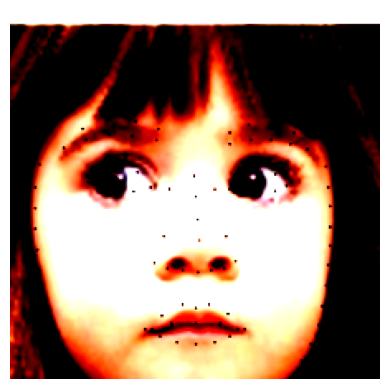

In [25]:
plt.imshow(b[1].permute(1,2,3,0).squeeze(0).numpy()[:, :, ::-1] )
plt.axis('off')  # Optional: turn off axes
plt.show()

In [16]:
t[1].shape

(224, 224, 3)

# Code below is for ABAW, code above is for RAFDB

In [5]:
train_label_path = '/kaggle/input/abaw-7-dataset/training_set_annotations.txt'
val_label_path = '/kaggle/input/abaw-7-dataset/validation_set_annotations.txt'
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'

batch_size = 8
stride = 5
sequence_length = 10

train_seqs, train_labels = sequence_extractor(
    data_dict = data_builder(train_label_path, train = False),
    data_path = data_path,
    min_stride = stride,
    sequence_length = sequence_length
)

val_seqs, val_labels = sequence_extractor(
    data_dict = data_builder(val_label_path, train = False),
    data_path = data_path,
    min_stride = stride,
    sequence_length = sequence_length,
    train = False
)

train_dataset = ABAWFeatureDataset(train_seqs, train_labels, transform = T.Compose([
        T.RandomHorizontalFlip(p=0.5),  # Flip the frame with a probability of 0.5
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),  # Converts the image to a tensor and normalizes to [0, 1]
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),  # Normalization using ImageNet mean and std
    ])
)
val_dataset = ABAWFeatureDataset(val_seqs, val_labels, transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
    ])
)

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)

dataloaders = {
    "train": data_loader_train,
    "test": data_loader_val
}

dataset_sizes = {
    "train": len(train_dataset),
    "test": len(val_dataset)
}

dataset_sizes

/tmp/ipykernel_34/3951147203.py:3: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(label_path, names = ['image', 'val', 'arousal', 'expr', 'au1', 'au2', 'au3', 'au4', 'au5', 'au6', 'au7', 'au8', 'au9', 'au10', 'au11', 'au12'] )
/tmp/ipykernel_34/3951147203.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['folder'], as_index= False).apply(lambda x: x.sort_values('image'))


ValueError: range() arg 3 must not be zero

# Model Training

In [26]:
model = torchvision.models.video.swin3d_b(weights="KINETICS400_IMAGENET22K_V1")

# model = torchvision.models.video.swin3d_b(weights=None)

# state_dict = torch.load('/kaggle/working/trained_model/freezing_epoch_10.pth', map_location=torch.device('cpu'))

# Step 3: Apply the loaded weights to the model
# model.load_state_dict(state_dict)

num_ftrs = model.head.in_features # Get the input features of the current head

# Step 2: Create a new head
new_head = nn.Sequential(
 nn.Linear(num_ftrs, 7) # Final layer with 3 output units (for 3 classes)
)

model.head = new_head

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for name, param in model.named_parameters():
    if any(layer_name in name for layer_name in ["features.6", "norm", "avgpool", "head"]):
        param.requires_grad = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# app.prepare(ctx_id=0, det_size=(640, 640))
# app.to(device)

run = 12
# learning_rate = 0.001
learning_rate = 0.01

# labels_np = np.array(train_labels)
# class_counts = np.bincount(labels_np)          # Generate class counts
# class_weights = 1.0 / class_counts             # Calculate inverse of class counts
# class_weights = class_weights / class_weights.sum()            # Normalize the weights to sum to 1 (optional)
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# criterion = LabelSmoothingCrossEntropy()
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=learning_rate)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
writer = SummaryWriter(f'run{run}')

Downloading: "https://download.pytorch.org/models/swin3d_b_22k-7c6ae6fa.pth" to /root/.cache/torch/hub/checkpoints/swin3d_b_22k-7c6ae6fa.pth
100%|██████████| 364M/364M [00:09<00:00, 39.0MB/s] 


In [16]:
os.remove('/kaggle/working/run10/events.out.tfevents.1726030396.9ef0d19968e3.34.0')

In [ ]:
for name, param in model.named_parameters():
    print(name)

In [27]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, writer, run, num_epochs=20, app=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    step = -1
    best_f1 = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)
        flag = True
        if epoch % 3 == 0:
            step += 1
        
        data_loader_train, train_len, dataset_train = get_analysis_train_dataloader(data_path, label_path, batch_size, num_epochs = num_epochs, epochs = step)
        data_loader_val, val_len, dataset_val = get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = num_epochs, epochs = step)

        dataloaders = {
            "train": data_loader_train,
            "test": data_loader_val
        }

        dataset_sizes = {
            "train": train_len,
            "test": val_len
        }
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            all_preds = []
            all_labels = []
            
            for input1, input2, labels in tqdm(dataloaders[phase]):
                if phase == 'train':
#                     inputs = torch.cat((input1, input2), dim = 0)
#                     labels = torch.cat((labels, labels), dim = 0)
#                     training with no augmentations
                    inputs = input2
                    if flag:
                        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
                        # Display the original image (input1[0]) in the first subplot
                        axes[0].imshow(input1[0].permute(1, 2, 3, 0).squeeze(0))  # Assuming input1[0] is in (C, H, W) format
                        axes[0].set_title('Original')  # Add heading
                        axes[0].axis('off')  # Turn off the axes
                        # Display the augmented image (input2[0]) in the second subplot
                        axes[1].imshow(input2[0].permute(1, 2, 3,  0).squeeze(0))  # Assuming input2[0] is in (C, H, W) format
                        axes[1].set_title('Augmented')  # Add heading
                        axes[1].axis('off')  # Turn off the axes
                        # Show the figure with both images
                        plt.tight_layout()
                        plt.show()
#                         plt.imshow(input2[0].permute(1,2,3,0).squeeze(0))
#                         plt.axis('off')  # Optional: turn off axes
#                         plt.show()
                        flag = False
                else:
                    inputs = input1
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
#             if phase == 'train' and (epoch+1) % 5 == 0:
#                 scheduler.step()
#                 torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase6_freezing_epoch_{epoch}.pth')
            epoch_loss = running_loss / (dataset_sizes[phase] * (1 if phase == 'train' else 1))
            epoch_acc = running_corrects.double() / (dataset_sizes[phase] * (1 if phase == 'train' else 1))
            # Calculate F1 score, precision, and recall
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")
            
            # Log the metrics
            writer.add_scalar(f'{phase}{run}/Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}{run}/Accuracy', epoch_acc, epoch)
            writer.add_scalar(f'{phase}{run}/F1', epoch_f1, epoch)
            writer.add_scalar(f'{phase}{run}/Precision', epoch_precision, epoch)
            writer.add_scalar(f'{phase}{run}/Recall', epoch_recall, epoch)
            
            # Log the learning rate as a scalar
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar(f'{phase}{run}/Learning_Rate', current_lr, epoch)
            
            if phase == 'test' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase_{run}_best.pth')  # Save the model

        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase{run}freezing_final_epoch_{num_epochs}.pth')  # Save the model
    best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model

In [28]:
# Increase the message rate limit for printing training progress
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {
    "NotebookApp": {
        "iopub_msg_rate_limit": 10000,  # Increase to 10000 messages/sec
        "rate_limit_window": 10.0,      # Increase the rate limit window to 10 seconds
    }
})

Epoch 0/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

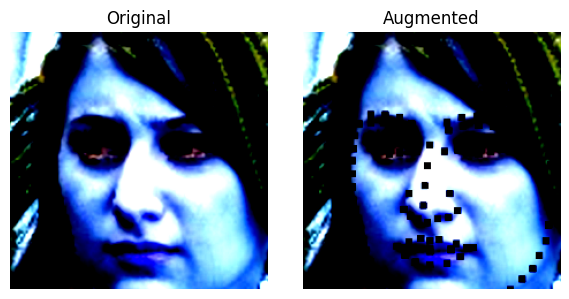

train Loss: 2.4665 Acc: 0.7061 F1: 0.7082 Precision: 0.7109 Recall: 0.7070


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 106.1794 Acc: 0.2216 F1: 0.0804 Precision: 0.0491 Recall: 0.2216

Epoch 1/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

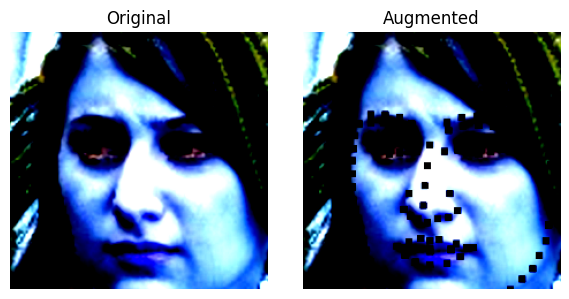

train Loss: 8.4244 Acc: 0.6903 F1: 0.6905 Precision: 0.6902 Recall: 0.6912


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 51.1549 Acc: 0.2826 F1: 0.1924 Precision: 0.5277 Recall: 0.2826

Epoch 2/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

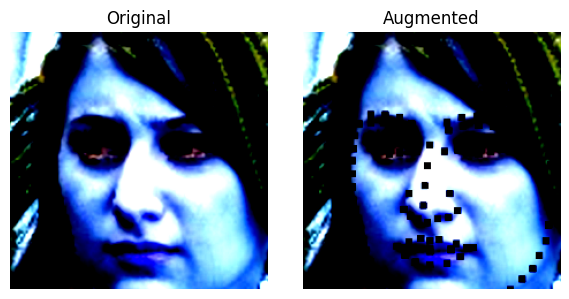

train Loss: 5.2166 Acc: 0.7116 F1: 0.7116 Precision: 0.7109 Recall: 0.7125


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 50.3244 Acc: 0.3292 F1: 0.2649 Precision: 0.5724 Recall: 0.3292

Epoch 3/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

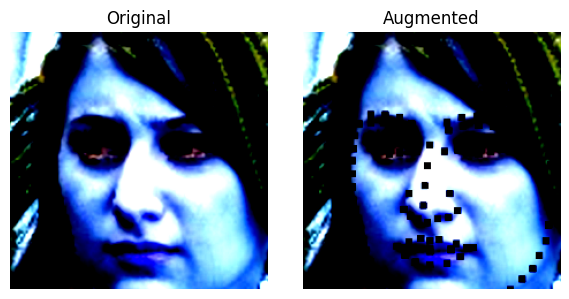

train Loss: 4.9374 Acc: 0.7193 F1: 0.7195 Precision: 0.7190 Recall: 0.7201


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 48.4311 Acc: 0.3680 F1: 0.3181 Precision: 0.5709 Recall: 0.3680

Epoch 4/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

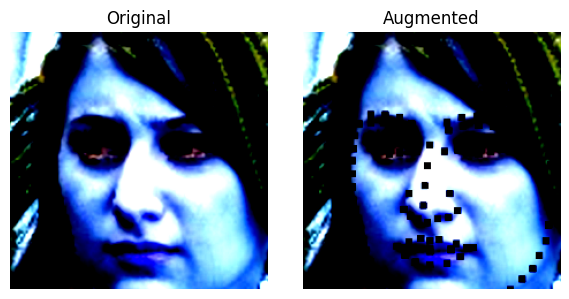

train Loss: 4.8234 Acc: 0.7184 F1: 0.7188 Precision: 0.7184 Recall: 0.7193


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 46.8753 Acc: 0.3817 F1: 0.3296 Precision: 0.5659 Recall: 0.3817

Epoch 5/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

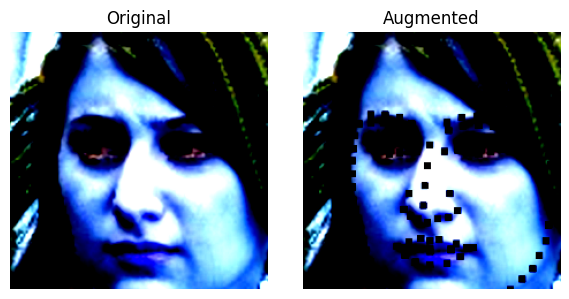

train Loss: 4.7333 Acc: 0.7247 F1: 0.7252 Precision: 0.7248 Recall: 0.7256


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 47.4097 Acc: 0.4025 F1: 0.3558 Precision: 0.5838 Recall: 0.4025

Epoch 6/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

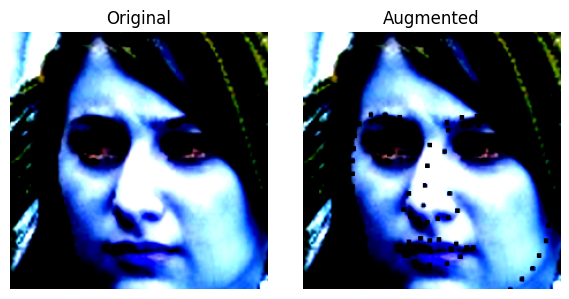

train Loss: 4.9906 Acc: 0.7429 F1: 0.7441 Precision: 0.7444 Recall: 0.7438


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 50.2537 Acc: 0.4126 F1: 0.3657 Precision: 0.5753 Recall: 0.4126

Epoch 7/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

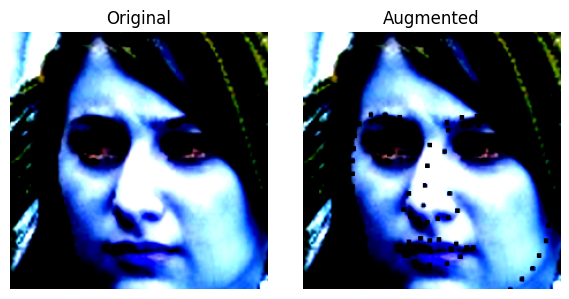

train Loss: 5.1981 Acc: 0.7496 F1: 0.7500 Precision: 0.7496 Recall: 0.7505


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 46.2829 Acc: 0.4322 F1: 0.3921 Precision: 0.6069 Recall: 0.4322

Epoch 8/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

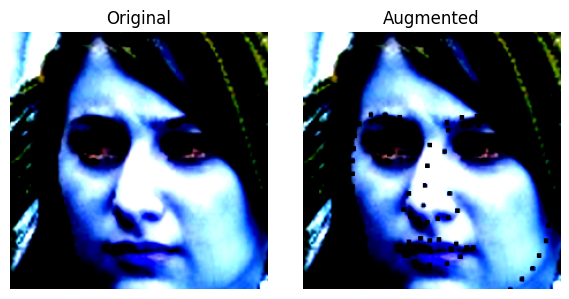

train Loss: 5.0955 Acc: 0.7478 F1: 0.7483 Precision: 0.7480 Recall: 0.7487


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 43.9021 Acc: 0.4410 F1: 0.4064 Precision: 0.6110 Recall: 0.4410

Epoch 9/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

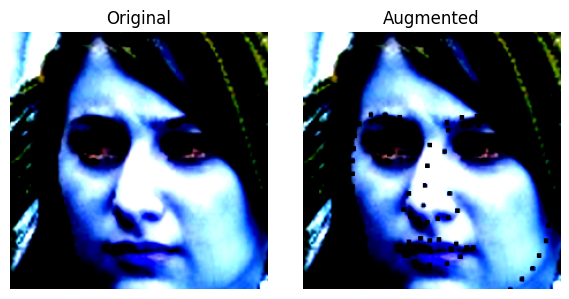

train Loss: 4.7784 Acc: 0.7548 F1: 0.7557 Precision: 0.7556 Recall: 0.7557


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 42.4892 Acc: 0.4407 F1: 0.4041 Precision: 0.5891 Recall: 0.4407

Epoch 10/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

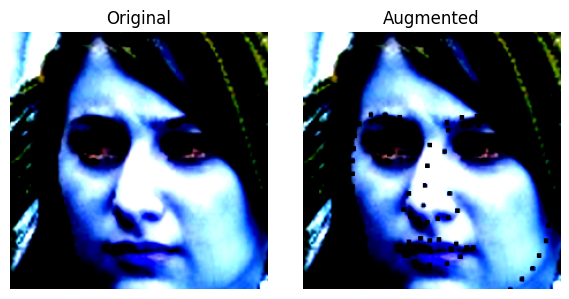

train Loss: 4.7522 Acc: 0.7550 F1: 0.7558 Precision: 0.7556 Recall: 0.7559


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 40.1678 Acc: 0.4674 F1: 0.4331 Precision: 0.6072 Recall: 0.4674

Epoch 11/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

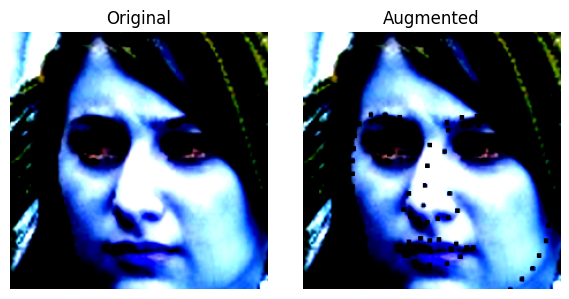

train Loss: 4.7271 Acc: 0.7600 F1: 0.7608 Precision: 0.7608 Recall: 0.7609


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 40.5908 Acc: 0.4557 F1: 0.4209 Precision: 0.5865 Recall: 0.4557

Epoch 12/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

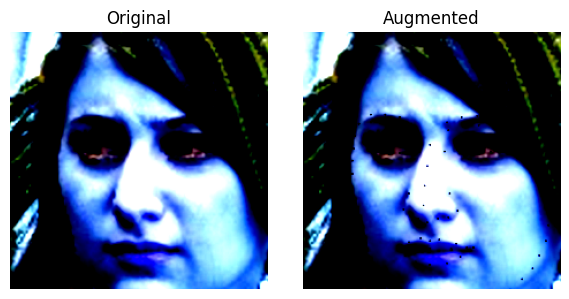

train Loss: 4.4607 Acc: 0.7769 F1: 0.7775 Precision: 0.7772 Recall: 0.7778


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 37.5867 Acc: 0.4540 F1: 0.4199 Precision: 0.6379 Recall: 0.4540

Epoch 13/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

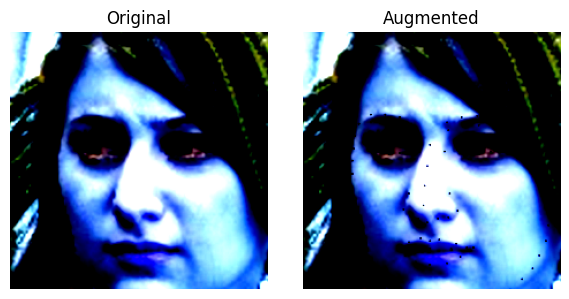

train Loss: 4.0022 Acc: 0.7818 F1: 0.7826 Precision: 0.7825 Recall: 0.7828


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 34.8643 Acc: 0.4537 F1: 0.4264 Precision: 0.6505 Recall: 0.4537

Epoch 14/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

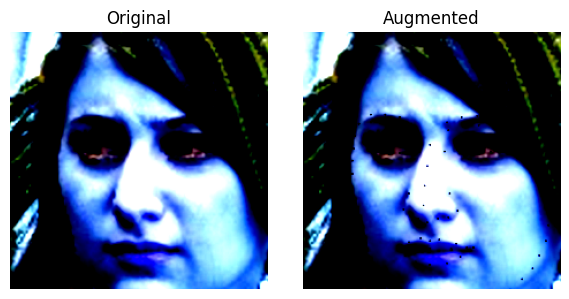

train Loss: 3.8164 Acc: 0.7845 F1: 0.7855 Precision: 0.7856 Recall: 0.7855


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 35.8907 Acc: 0.4514 F1: 0.4239 Precision: 0.6435 Recall: 0.4514

Epoch 15/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

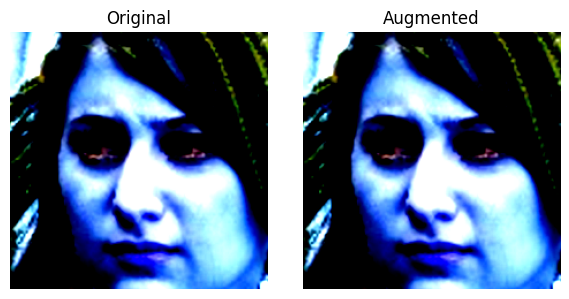

train Loss: 3.6560 Acc: 0.7875 F1: 0.7886 Precision: 0.7889 Recall: 0.7884


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 40.8596 Acc: 0.4241 F1: 0.3899 Precision: 0.6289 Recall: 0.4241

Epoch 16/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

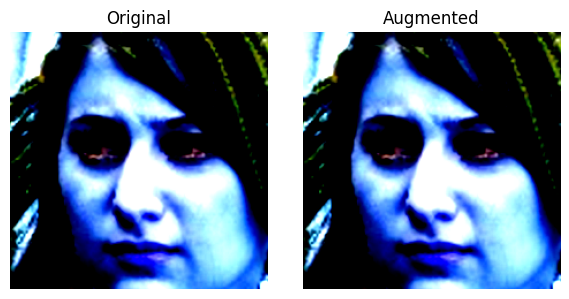

train Loss: 3.6819 Acc: 0.7892 F1: 0.7903 Precision: 0.7906 Recall: 0.7901


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 41.5527 Acc: 0.4211 F1: 0.3864 Precision: 0.6217 Recall: 0.4211

Epoch 17/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

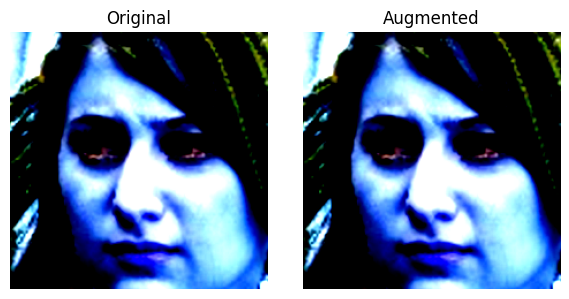

train Loss: 3.5376 Acc: 0.7931 F1: 0.7941 Precision: 0.7941 Recall: 0.7941


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 41.7696 Acc: 0.4218 F1: 0.3863 Precision: 0.6584 Recall: 0.4218

Epoch 18/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

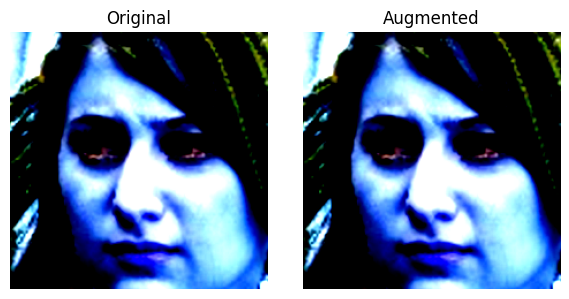

train Loss: 3.4586 Acc: 0.7928 F1: 0.7936 Precision: 0.7934 Recall: 0.7938


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 36.7226 Acc: 0.4169 F1: 0.3881 Precision: 0.6382 Recall: 0.4169

Epoch 19/19
----------


  0%|          | 0/383 [00:00<?, ?it/s]

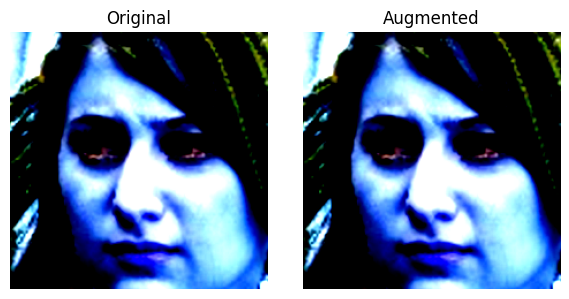

train Loss: 3.0724 Acc: 0.8012 F1: 0.8023 Precision: 0.8026 Recall: 0.8021


  0%|          | 0/96 [00:00<?, ?it/s]

test Loss: 37.8578 Acc: 0.4436 F1: 0.4136 Precision: 0.6731 Recall: 0.4436

Training complete in 98m 32s


In [29]:
num_epochs = 20

description = (
    f"Training parameters for RAFDB with FiFA reducing patch sizes:\n"
    f"Model: {model.__class__.__name__}\n"
    f"Criterion: {criterion.__class__.__name__}\n"
    f"Optimizer: {optimizer.__class__.__name__}\n"
    f"Scheduler: {exp_lr_scheduler.__class__.__name__}\n"
    f"Device: {device}\n"
    f"Number of epochs: {num_epochs}\n"
    f"Batch Size: {batch_size}\n"
#     f"Stride: {stride}\n"
#     f"Sequence Length: {sequence_length}"
)
writer.add_text(f"Desc_{run}/Training Parameters", description, global_step=0)
model_ft = train_model(model,criterion, optimizer, exp_lr_scheduler, dataloaders = None, dataset_sizes = None, device = device, writer = writer, run = run, num_epochs=num_epochs)

In [39]:
 torch.save(model.state_dict(), f'/kaggle/working/trained_model/rafDB_Fiducial_14_epochs.pth')

In [89]:
inputs = torch.cat((a, b), dim = 0)
labels = torch.cat((c, c), dim = 0)

inputs.shape

torch.Size([32, 3, 1, 224, 224])

In [70]:

a.unsqueeze(0).shape

torch.Size([1, 16, 3, 224, 224])

In [90]:
x = inputs.to(device)
t = model(x)

In [91]:
t.shape

torch.Size([32, 7])

# Independent Validation

In [15]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
val_seqs, val_labels = sequence_extractor(
    data_dict = data_builder(val_label_path, train = False),
    data_path = data_path,
    min_stride = 1,
    sequence_length = 5,
    train = False
)

val_dataset = ABAWFeatureDataset(val_seqs, val_labels, transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
    ])
)

data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)


In [ ]:
running_loss = 0.0
running_corrects = 0.0
all_preds = []
all_labels = []
            
    
for inputs, labels in tqdm(data_loader_val):
    inputs = inputs.to(device)
    labels = labels.to(device)

#     optimizer.zero_grad()

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects.double() / dataset_sizes['val']

# Calculate F1 score, precision, and recall
epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"{'val'} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")
            

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Example list of image paths
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'
image_paths = [os.path.join(data_path, x) for x in train_seqs[0]]
labels = [train_labels[0] for x in train_seqs[0]]
# Number of images
n_images = len(image_paths)

# Calculate grid size (assuming a square grid)
grid_size = int(n_images**0.5) + (n_images**0.5 != int(n_images**0.5))

# Create a figure with a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over images and plot them with labels
for i, (image_path, label) in enumerate(zip(image_paths, labels)):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(label, fontsize=12)  # Add label

# Hide any remaining empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Testing Facial Landmark detector on cuda

In [11]:
# app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# app.prepare(ctx_id=0, det_size=(640, 640))  # Set detection size, though not used directly for cropped images

# Example usage
cropped_face_path = '/kaggle/input/raf-db-trial/92_86/92/dataset/RAF/test_0001.jpg'
cropped_face = cv2.imread(cropped_face_path)
top = 100
bottom = 100
left = 100
right = 100

# Pad the image
padded_image = cv2.copyMakeBorder(
    cropped_face,
    top,
    bottom,
    left,
    right,
    cv2.BORDER_CONSTANT,  # Border type
    value=[0, 0, 0]       # Padding color (black in this case)
)
# cv2_imshow(padded_image)
for i in range(10):
    out = app.get(padded_image)

Build a dynamic FER model which takes video 